### Image Preprocessing & Pipeline Notebook 

This notebook covers the full preprocessing pipeline for image-based modeling.

Steps included:
1. Setup & configuration
2. Loading metadata and linking tweet_id -> image file
3. Basic image loading & sanity checks
4. Image resizing baseline
5. Data augmentations
6. OCR text extraction pipeline
7. Feature serialization for future multimodal integration
8. Utility functions

In [1]:
# Libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import easyocr

# Paths
data_path = "../../data/"
img_path = "../../data/images"
AUGMENTED = False

c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load Data
if AUGMENTED:
    train_path = os.path.join(data_path, "train_augmented_synonym.csv")
else:
    train_path = os.path.join(data_path, "train.csv")

dev_path = os.path.join(data_path, "dev.csv")
test_path = os.path.join(data_path, "test.csv")

# Load data
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

for df, split in [(train_df, "train"), (dev_df, "dev"), (test_df, "test")]:
    if "split" not in df.columns:
        df["split"] = split

df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

df.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train


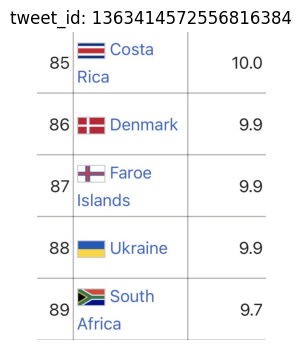

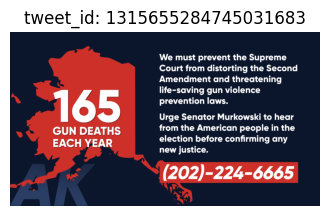

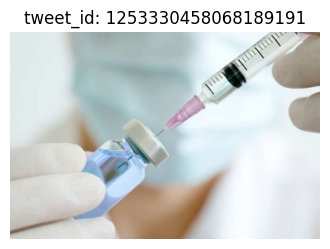

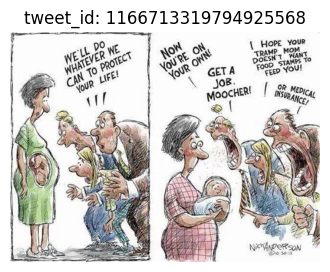

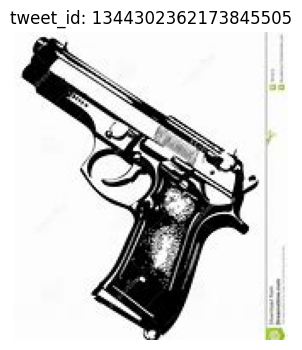

In [3]:
#Load Images Function

#Function to load image
def load_image(tweet_id, img_dir=img_path):
    path = os.path.join(img_dir, f"{tweet_id}.jpg")
    img = cv2.imread(path)
    #In case our image is corrupted
    if img is None:
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#We tested with some sample
df_sample = df.sample(5, random_state=42)

for idx, row in df_sample.iterrows():
    img = load_image(row["tweet_id"])
    if img is not None:
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.title(f"tweet_id: {row['tweet_id']}")
        plt.axis("off")
        plt.show()

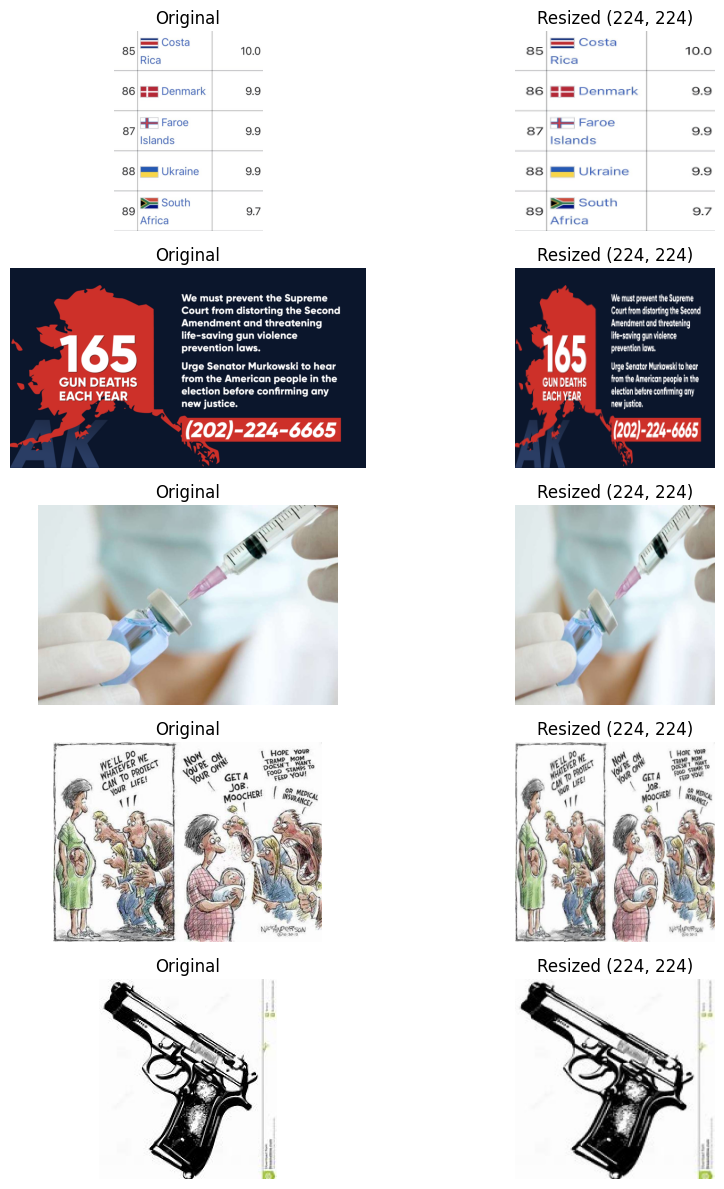

In [4]:
#Resize Function (Baseline)
TARGET_SIZE = (224, 224)

def resize_image(img, size=TARGET_SIZE):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)



fig, axes = plt.subplots(df_sample.shape[0], 2, figsize=(10, 12))
for i, (idx, row) in enumerate(df_sample.iterrows()):
    img = load_image(row["tweet_id"])
    if img is not None:

        #We resized the image
        img_resized = resize_image(img)
        
        #We show the original 
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original")
        axes[i, 0].axis("off")
        
        #We show the resized 
        axes[i, 1].imshow(img_resized)
        axes[i, 1].set_title(f"Resized {TARGET_SIZE}")
        axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_7860\1323535626.py:14: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=4, max_height=20, max_width=20, p=0.3), #Remove randomly small parts of the image


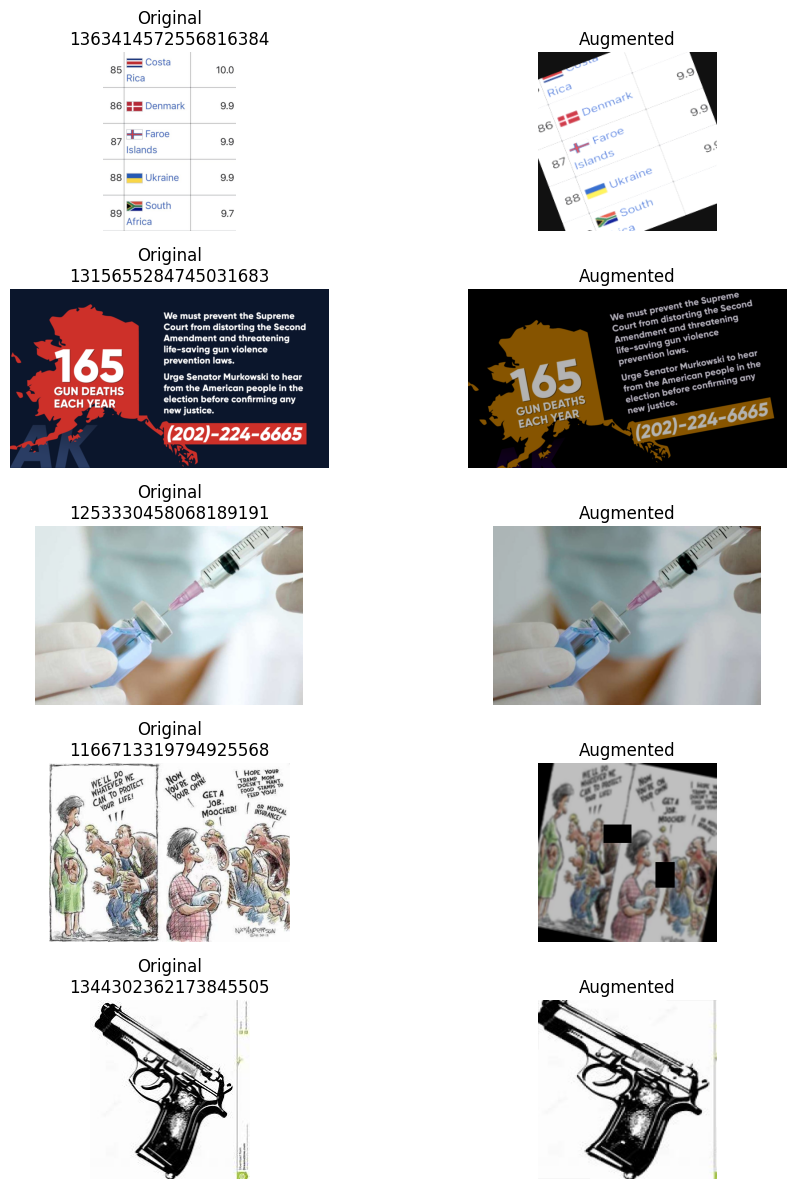

In [5]:
#Augmentation Pipeline (We will optimize/prune later, just a baseline to test)
augmentation_transform = A.Compose([
    A.RandomResizedCrop(
        size=(224, 224), #Target suze for the output image
        scale=(0.8, 1.0), # Range of the random sze of the crop
        ratio=(0.75, 1.33), #Range of aspect ratios of the crp
        interpolation=cv2.INTER_AREA, #Algorithnm to re dimension the image
        p=0.5), #Prob of applyting the transform 
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=25, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.Blur(blur_limit=3, p=0.2),
    A.CoarseDropout(max_holes=4, max_height=20, max_width=20, p=0.3), #Remove randomly small parts of the image
    ToTensorV2() # Output normalized tensor (C,H,W)
])


# We test the funciton
fig, axes = plt.subplots(df_sample.shape[0], 2, figsize=(10, 12)) 
for i, (idx, row) in enumerate(df_sample.iterrows()):
    img = load_image(row["tweet_id"])
    if img is not None:

        # Augmentation (Tensor)
        augmented = augmentation_transform(image=img)
        img_aug = augmented['image']  

        #Converted to array to plot it
        img_aug_np = img_aug.permute(1, 2, 0).numpy()

        #Original 
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original\n{row['tweet_id']}")
        axes[i, 0].axis("off")
        
        #Augmented
        axes[i, 1].imshow(img_aug_np)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


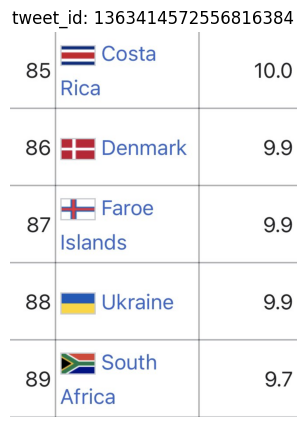

Text extracted for tweet_id 1363414572556816384:
Costa
85 Rica
10.0
86
Denmark
9.9
Faroe
87 Islands
9.9
88
Ukraine
9.9
South
89 Africa
9.7



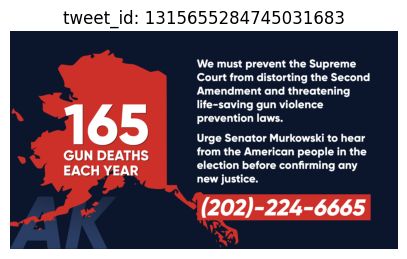

Text extracted for tweet_id 1315655284745031683:
We must prevent the Supreme Court from distorting the Second Amendment and threatening life-saving gun violence prevention laws. Urge Senator Murkowski to hear from the American people in the election before confirming any new justice: (202)-224-6665
165 GUN DEATHS EACH YEAR



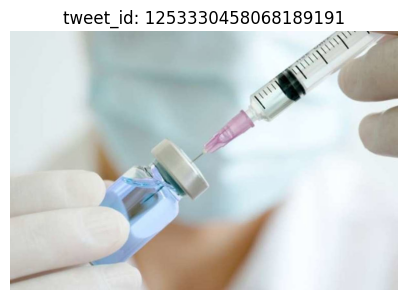

Text extracted for tweet_id 1253330458068189191:
[No text detected]



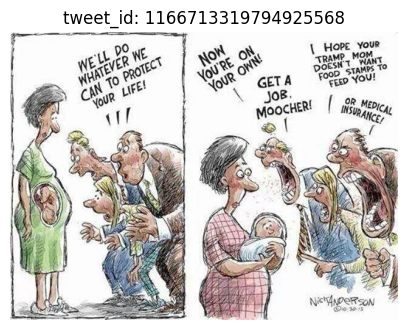

Text extracted for tweet_id 1166713319794925568:
WE oN HOPE Your MEYVB, Now PROTECT ~YoU RE ~Owi' 38E8 _ MOnito To 'Yovr ' GET A Foop FEED Svoti CAN Lifei Your Job MOOCHERI SBuraercca MeDical
Nic npeR-ON 90 % 



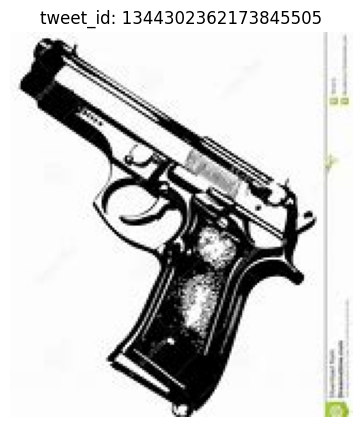

Text extracted for tweet_id 1344302362173845505:
[No text detected]



In [6]:
# Text Extraction (Using EasyOCR) / Used in EDA
reader = easyocr.Reader(['en'], gpu=True, verbose=False)

def extract_text_from_image(image_path):

    result = reader.readtext(image_path, paragraph=True)
    if not result:
        return ""
    paragraphs = [text for bbox, text in result]
    formatted_text = "\n".join(paragraphs)
    
    return formatted_text


figsize_per_image = (5, 5)
for i, (idx, row) in enumerate(df_sample.iterrows()):
    img = load_image(row["tweet_id"])
    if img is not None:
        
        #Extract Text
        extracted_text = extract_text_from_image(img)
        
        #We Plot
        plt.figure(figsize=figsize_per_image)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"tweet_id: {row['tweet_id']}")
        plt.show()
        
        # Print
        print(f"Text extracted for tweet_id {row['tweet_id']}:\n{extracted_text if extracted_text else '[No text detected]'}\n")

In [ ]:
# Preprocessing Pipeline for Saving Outputs
#Run just in case we need to re save outputs !!!

OUTPUT_DIR= "../../data/preprocessed_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create storage for extracted OCR
ocr_records = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    tid = row["tweet_id"]
    img = load_image(tid)
    if img is None:
        continue
    
    # Resize
    resized = resize_image(img)

    # Save resized img
    out_path = os.path.join(OUTPUT_DIR, f"{tid}_224.jpg")
    cv2.imwrite(out_path, cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

    # OCR
    ocr_text = extract_text_from_image(resized)
    ocr_records.append({
        "tweet_id": tid,
        "ocr_text": ocr_text,
        "split": row["split"]
    })

#We left-join OCR Text with our original df.
ocr_df = pd.DataFrame(ocr_records)
merged = df.merge(ocr_df, on=["tweet_id", "split"], how="left")
merged.to_csv(os.path.join(OUTPUT_DIR, "df_with_OCR.csv"), index=False)
print("Saved merged df OCR.")